In [1]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
directory = os.getcwd()
data_all = pd.read_csv(directory + '/input_data.csv', sep=',') 

In [3]:
#all columns
data_all.head()

,INITIAL_SEVERITY_LEVEL_CODE,DISPATCH_RESPONSE_SECONDS_QY,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,HELD_INDICATOR,T0,T1,T3,T4,T5,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,5,4,740.0,736.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2,24,409.0,385.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,5,15,596.0,581.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,29,501.0,472.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,3,56,264.0,208.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


***INCLUDING IMPORTANT FEATURES ONLY***

In [4]:
data =data_all.drop(columns = 'DISPATCH_RESPONSE_SECONDS_QY')

In [5]:
#df without dispatch response seconds
data.head()

,INITIAL_SEVERITY_LEVEL_CODE,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,HELD_INDICATOR,T0,T1,T3,T4,T5,T6,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,5,740.0,736.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2,409.0,385.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,5,596.0,581.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,501.0,472.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3,264.0,208.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
data.shape

(50000, 603)

***BINNING INCIDENT_TRAVEL_TM (DISCRETIZING)***

In [7]:
#bins; change n to change num of bins
n = 5 
max = 1025
bin_width = max/n #+1 because we have n bins so n+1 endpoints
bin_width

205.0

In [8]:
#bin ranges
bins = np.linspace(0,max,n+1)
bins

array([   0.,  205.,  410.,  615.,  820., 1025.])

In [9]:
#labels for bin ranges
labels = list(range(1,n+1))
labels

[1, 2, 3, 4, 5]

In [10]:
#df to visualize bins
df = pd.DataFrame(data = labels)
df['start'] = bins[:bins.shape[0]-1]
df['end'] = bins[1:]
df

,0,start,end
0,1,0.0,205.0
1,2,205.0,410.0
2,3,410.0,615.0
3,4,615.0,820.0
4,5,820.0,1025.0


In [11]:
#coding continuous data based on bins/labels, removing continuous data cols
data['INCIDENT_TRAVEL_TM_SECONDS_QY_Bin'] = pd.cut(data['INCIDENT_TRAVEL_TM_SECONDS_QY'],bins,labels=labels)
data = data.drop(columns = ['INCIDENT_TRAVEL_TM_SECONDS_QY'])
data.head()

,INITIAL_SEVERITY_LEVEL_CODE,INCIDENT_RESPONSE_SECONDS_QY,HELD_INDICATOR,T0,T1,T3,T4,T5,T6,T7,...,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,INCIDENT_TRAVEL_TM_SECONDS_QY_Bin
0,5,740.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,4
1,2,409.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
2,5,596.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3
3,1,501.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,3
4,3,264.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,2


In [12]:
import collections
from collections import Counter

In [13]:
travel_tm = collections.Counter(data["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"])
travel_tm_count = sum(travel_tm.values())
travel_tm

Counter({4: 5700, 2: 22025, 3: 14376, 5: 2210, 1: 5689})

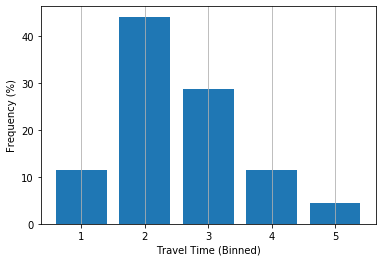

In [14]:
#visualize count of data within each bin
travel_tm = {k: (v*100) / travel_tm_count for k, v in travel_tm.items()} #mult by 100 to turn into percent
plt.bar(travel_tm.keys(),travel_tm.values())
plt.grid(axis = 'x')
plt.xlabel("Travel Time (Binned)")
plt.ylabel("Frequency (%)")
plt.show()

***SPLITTING TRAIN / TEST***

In [15]:
#X is predictors, Y is value to be predicted
X = data.drop(columns = ["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"])
Y = data["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"]

#splitting into training and testing datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)

***LINEAR DISCRIMINANT ANALYSIS***

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [17]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train,Y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [18]:
lda.score(X_train,Y_train)

0.94472

In [19]:
lda.score(X_test,Y_test)

0.93808

In [20]:
Y_lda_predict = lda.predict(X_test)
Y_lda_predict

array([2, 2, 4, ..., 3, 3, 1])

In [21]:
print("=== Classification Report ===")
print(classification_report(Y_test, Y_lda_predict))

=== Classification Report ===
              precision    recall  f1-score   support

           1       0.92      0.89      0.91      1402
           2       0.94      0.96      0.95      5529
           3       0.94      0.93      0.93      3577
           4       0.94      0.92      0.93      1459
           5       0.94      0.96      0.95       533

    accuracy                           0.94     12500
   macro avg       0.94      0.93      0.93     12500
weighted avg       0.94      0.94      0.94     12500



In [22]:
print("=== Confusion Matrix ===")
print(confusion_matrix(Y_test, Y_lda_predict))

=== Confusion Matrix ===
[[1253  149    0    0    0]
 [ 104 5283  142    0    0]
 [   0  172 3334   71    0]
 [   0    0   85 1344   30]
 [   0    0    0   21  512]]


***KNN***

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
#default parameters
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [25]:
knn.score(X_train, Y_train)

0.9578933333333334

In [26]:
knn.score(X_test, Y_test)

0.94384

In [27]:
Y_knn_predict = knn.predict(X_test)
Y_knn_predict

array([2, 2, 5, ..., 3, 3, 1])

In [28]:
print("=== Classification Report ===")
print(classification_report(Y_test, Y_knn_predict))

=== Classification Report ===
              precision    recall  f1-score   support

           1       0.95      0.91      0.93      1402
           2       0.96      0.95      0.96      5529
           3       0.93      0.94      0.94      3577
           4       0.92      0.94      0.93      1459
           5       0.94      0.96      0.95       533

    accuracy                           0.94     12500
   macro avg       0.94      0.94      0.94     12500
weighted avg       0.94      0.94      0.94     12500



In [32]:
print("=== Confusion Matrix ===")
print(confusion_matrix(Y_test, Y_knn_predict))

=== Confusion Matrix ===
[[1288  140    0    0    0]
 [  78 5240  168    0    0]
 [   0  111 3422   89    0]
 [   0    0   64 1353   40]
 [   0    0    0   20  487]]


***Hyperparameter Tuning***

In [37]:
#comparing error rate vs. K value between 1 and 40
#bins = 5
error = []
acc = []

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, Y_train)
    pred = knn.predict(X_test)
    error.append(np.mean(pred != Y_test))

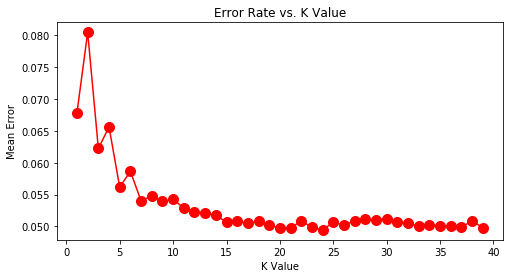

In [38]:
#once K reaches ~20, the error rate is constantly ~0
plt.figure(figsize=(8, 4))
plt.plot(range(1, 40), error, color='red',  marker='o', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()

***Sample Size vs. Score***

In [39]:
import random
import numpy as np
import pandas as pd 
from sklearn import linear_model
from sklearn.svm import SVC
#IMPORT YOUR PACKAGES

np.random.seed(2019)

In [40]:
directory = os.getcwd()
data_all = pd.read_csv(directory + '/input_data.csv', sep=',')

In [41]:
## REPLACE THIS WITH MY EXECUTED DICT AND NEW MODEL NAMES+BIN ##
summary_dict = {"KNN5":[],"KNN12":[],"KNN25":[],"KNN41":[],}

In [42]:
num_bins = [5, 12, 25, 41]
samplesize = [1000, 5000, 10000, 25000, 50000]

for n in num_bins:
    
    max = 1025
    bin_width = max/n

    bins = np.linspace(0,max,n+1)
    labels = list(range(1,n+1))
    
    data =data_all.drop(columns = 'DISPATCH_RESPONSE_SECONDS_QY')
    data['INCIDENT_TRAVEL_TM_SECONDS_QY_Bin'] = pd.cut(data['INCIDENT_TRAVEL_TM_SECONDS_QY'],bins,labels=labels)
    data = data.drop(columns = ['INCIDENT_TRAVEL_TM_SECONDS_QY'])
    
    ##REPLACE STRING DEFINING MODEL BELOW##
    row_label = 'KNN' + str(n)

    for s in samplesize:
    
        data_sampled = data.sample(n = s)
        
        X = data_sampled.drop(columns = ["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"])
        Y = data_sampled["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"]

        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)
        
        ## REPLACE MODEL below ##
        
        knn = KNeighborsClassifier(n_neighbors = 20)
        knn.fit(X_train, Y_train)

        score = knn.score(X_test,Y_test)
                
        ## REPLACE MODEL above ##
        
        summary_dict[row_label].append(score)

In [43]:
summary_dict

{'KNN5': [0.924, 0.9472, 0.9516, 0.94192, 0.94904],
 'KNN12': [0.864, 0.8568, 0.8708, 0.88448, 0.87616],
 'KNN25': [0.716, 0.7168, 0.7492, 0.73968, 0.74248],
 'KNN41': [0.576, 0.632, 0.6088, 0.61664, 0.62136]}

In [45]:
df = pd.DataFrame.from_dict(summary_dict,orient = 'index',columns = ['1K','5K','10K','25K','50K'])
df

,1K,5K,10K,25K,50K
KNN5,0.924,0.9472,0.9516,0.94192,0.94904
KNN12,0.864,0.8568,0.8708,0.88448,0.87616
KNN25,0.716,0.7168,0.7492,0.73968,0.74248
KNN41,0.576,0.6320,0.6088,0.61664,0.62136


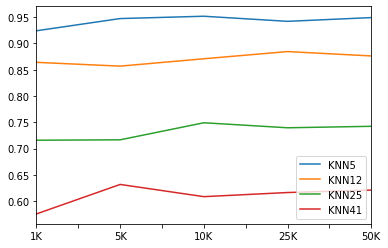

In [47]:
df.transpose().plot()
plt.legend(loc =4)